In [ ]:
#We import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,get_linear_schedule_with_warmup)
import warnings
warnings.filterwarnings('ignore')
from datasets import load_dataset
from torch import optim
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
#We ensure that the project runs on CPU
device = torch.device('cpu') 

In [ ]:
#We load and explore quickly the dataset
from datasets import load_dataset
dataset =load_dataset("imdb")

In [ ]:
#We split the dataset into train and test dfs
train_df =dataset["train"].to_pandas()
test_df =dataset["test"].to_pandas()

In [ ]:
#We remove the ordering biais of the initial dataset
train_df =train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
#We sample 2250 negatives and 2250 positives for the training step
train_neg =train_df[train_df["label"] == 0].sample(2250, random_state=42)
train_pos = train_df[train_df["label"] == 1].sample(2250, random_state=42)

In [ ]:
#We concatenate both dfs
train_balanced =pd.concat([train_neg, train_pos]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
#We sample 1250 negatives and 1250 positives for the testing step
test_neg =test_df[test_df["label"] == 0].sample(1250, random_state=24)
test_pos =test_df[test_df["label"] == 1].sample(1250, random_state=24)
test_balanced =pd.concat([test_neg, test_pos]).sample(frac=1, random_state=24).reset_index(drop=True)
train_df =train_balanced
test_df =test_balanced
print(f"The training set size: {len(train_df)}")
print(f"The test set size: {len(test_df)}")

In [144]:
#We display basic info about the training set
print("\nHere's an overview of the training set:")
print(train_df.head())
print("\nPositive/Negative label distribution in the training set:")
print(train_df['label'].value_counts())
print("\nPositive/Negative label distribution in the test set:")
print(test_df['label'].value_counts())


Here's an overview of the training set:
                                                text  label  text_length
0  I haven't read through all the comments, but a...      1         1743
1  Any film in the early days of Orson Welles is ...      1         1887
2  I was lucky enough to get to see this film man...      1         1097
3  Of course I would have to give this film 10 ou...      1          719
4  Well, there you have it, another disillusion o...      0         2121

Positive/Negative label distribution in the training set:
label
1    2250
0    2250
Name: count, dtype: int64

Positive/Negative label distribution in the test set:
label
1    1250
0    1250
Name: count, dtype: int64


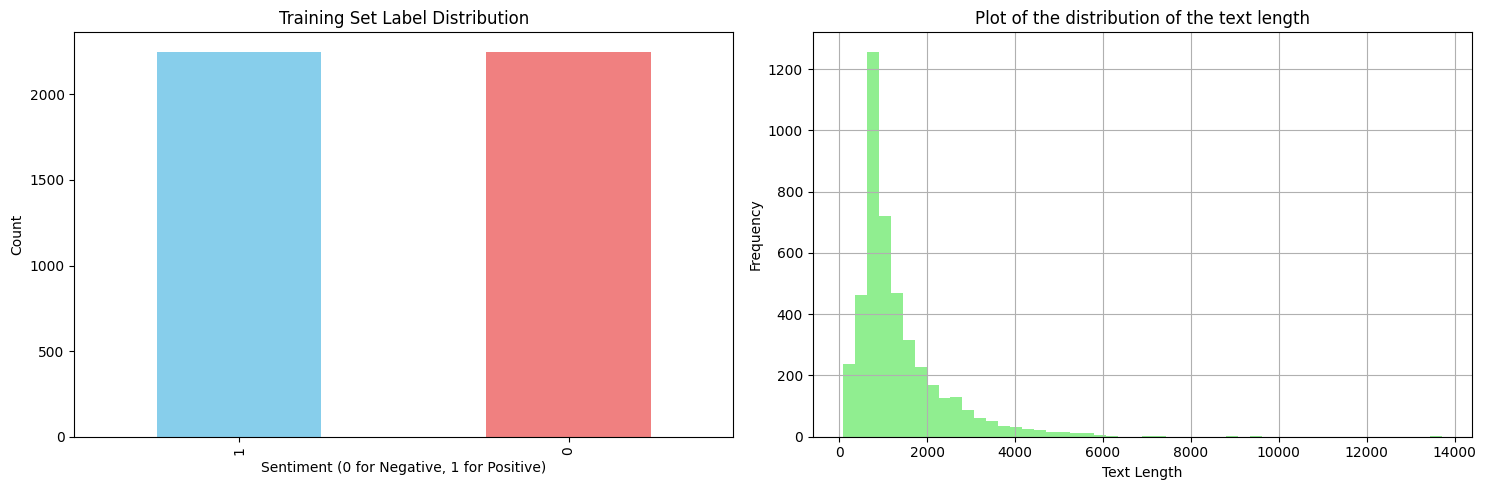

In [145]:
#We plot the data
fig,axes =plt.subplots(1,2,figsize=(15,5))

#The label distribution
train_df['label'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue','lightcoral']) 
axes[0].set_title('Training Set Label Distribution')
axes[0].set_xlabel('Sentiment (0 for Negative, 1 for Positive)')
axes[0].set_ylabel('Count')

#The movie reviews length distribution
train_df['text_length'] =train_df['text'].apply(len)
train_df['text_length'].hist(bins=50, ax=axes[1], color='lightgreen')
axes[1].set_title('Plot of the distribution of the text length')
axes[1].set_xlabel('Text Length')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

For the fine-tuning step of our model, we follow the project guideline of using CPU. This requires us to make choices in order to accelerate the training.
One of these choices include setting a max sequence length of 256 tokens.

Using device: cpu
Training set size: 4500
Test set size: 2500

Dataset Overview:
                                                text  label
0  I haven't read through all the comments, but a...      1
1  Any film in the early days of Orson Welles is ...      1
2  I was lucky enough to get to see this film man...      1
3  Of course I would have to give this film 10 ou...      1
4  Well, there you have it, another disillusion o...      0

Label distribution in training set:
label
1    2250
0    2250
Name: count, dtype: int64

Label distribution in test set:
label
1    1250
0    1250
Name: count, dtype: int64


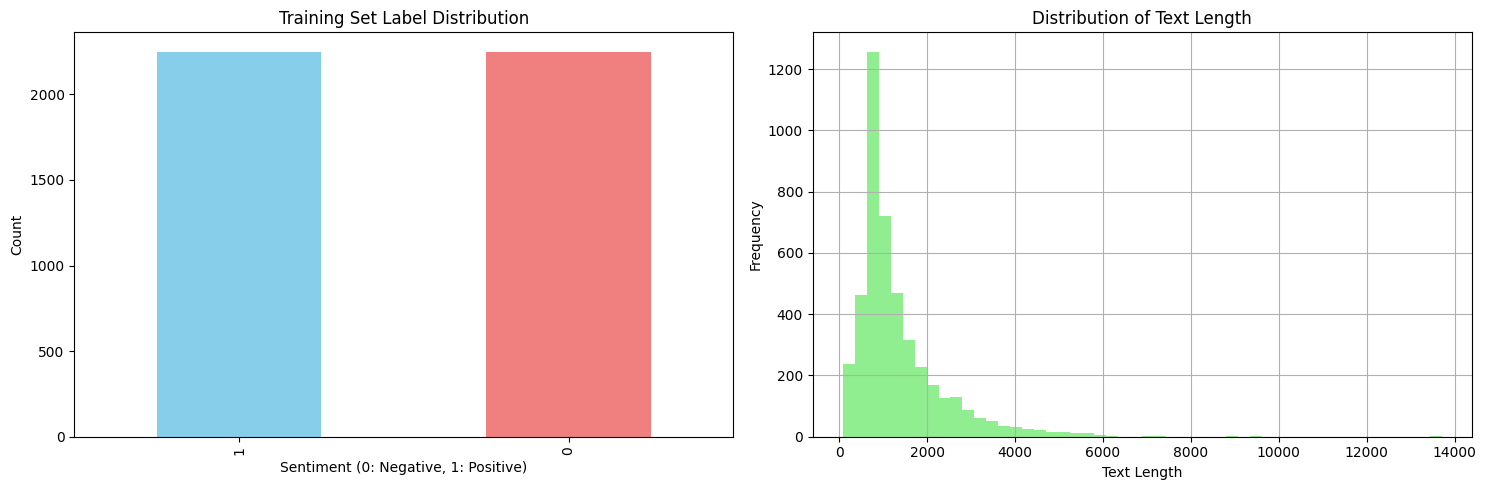

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training samples: 4050
Validation samples: 450
Test samples: 2500
Starting training...
Epoch 1/2
----------
Train loss: 0.3991, Train accuracy: 0.8123
Val loss: 0.3033, Val accuracy: 0.8711

Epoch 2/2
----------
Train loss: 0.2097, Train accuracy: 0.9230
Val loss: 0.3383, Val accuracy: 0.8800



In [98]:
model_name = "distilbert-base-uncased"
tokenizer =AutoTokenizer.from_pretrained(model_name)

class IMDBDataset(Dataset):
    def init(self, texts, labels, tokenizer, max_length=256):
        self.texts=texts
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_length=max_length
    def len(self):
        return len(self.texts)
    def item(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt')
        return {'input_ids': encoding['input_ids'].flatten(),'attention_mask': encoding['attention_mask'].flatten(),'labels': torch.tensor(label, dtype=torch.long)}

#We prepare the datasets
train_texts =train_df['text'].tolist()
train_labels =train_df['label'].tolist()
test_texts =test_df['text'].tolist()
test_labels =test_df['label'].tolist()
train_texts,val_texts, train_labels, val_labels =train_test_split(train_texts,train_labels,test_size=0.1,random_state=42,stratify=train_labels)
print(f"The training samples: {len(train_texts)}")
print(f"The validation samples: {len(val_texts)}")
print(f"the test samples: {len(test_texts)}")
#We create the datasets
train_dataset=IMDBDataset(train_texts, train_labels, tokenizer)
val_dataset=IMDBDataset(val_texts, val_labels, tokenizer)
test_dataset=IMDBDataset(test_texts, test_labels, tokenizer)
#We create the data loaders
batch_size =16
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_dataset batch_size=batch_size,shuffle=False)

model=AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2)
model=model.to(device)

optimizer=optim.AdamW(model.parameters(), lr=2e-5)
total_steps =len(train_loader)*2
scheduler =get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss =0
    correct_predictions =0
    for batch in data_loader:
        input_ids=batch['input_ids'].to(device)
        attention_mask=batch['attention_mask'].to(device)
        labels=batch['labels'].to(device)
        optimizer.zero_grad()
        outputs=model(input_ids=input_ids,attention_mask=attention_mask)
        loss=criterion(outputs.logits, labels)
        _, preds=torch.max(outputs.logits, dim=1)
        correct_predictions+=torch.sum(preds == labels)
        total_loss+=loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    accuracy=correct_predictions.double()/len(data_loader.dataset)
    avg_loss=total_loss/len(data_loader)
    return avg_loss,accuracy

def eval_model(model, data_loader, device):
    model.eval()
    total_loss=0
    correct_predictions=0
    all_predictions=[]
    all_labels=[]
    with torch.no_grad():
        for batch in data_loader:
            input_ids =batch['input_ids'].to(device)
            attention_mask =batch['attention_mask'].to(device)
            labels =batch['labels'].to(device)
            outputs =model(input_ids=input_ids, attention_mask=attention_mask)
            loss =criterion(outputs.logits, labels)
            _, preds =torch.max(outputs.logits, dim=1)
            correct_predictions +=torch.sum(preds == labels)
            total_loss +=loss.item()
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy=correct_predictions.double()/len(data_loader.dataset)
    avg_loss=total_loss/len(data_loader)
    return avg_loss, accuracy, all_predictions, all_labels

print("Starting training...")
epochs = 2
train_losses =[]
val_losses =[]
train_accuracies = []
val_accuracies = []
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_loss, train_acc=train_epoch(model, train_loader, optimizer, device, scheduler)
    val_loss, val_acc, _, _=eval_model(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f'Train loss: {train_loss:.4f},Train accuracy: {train_acc:.4f}')
    print(f'Val loss: {val_loss:.4f},Val accuracy: {val_acc:.4f}')
    print()



### 3. Results

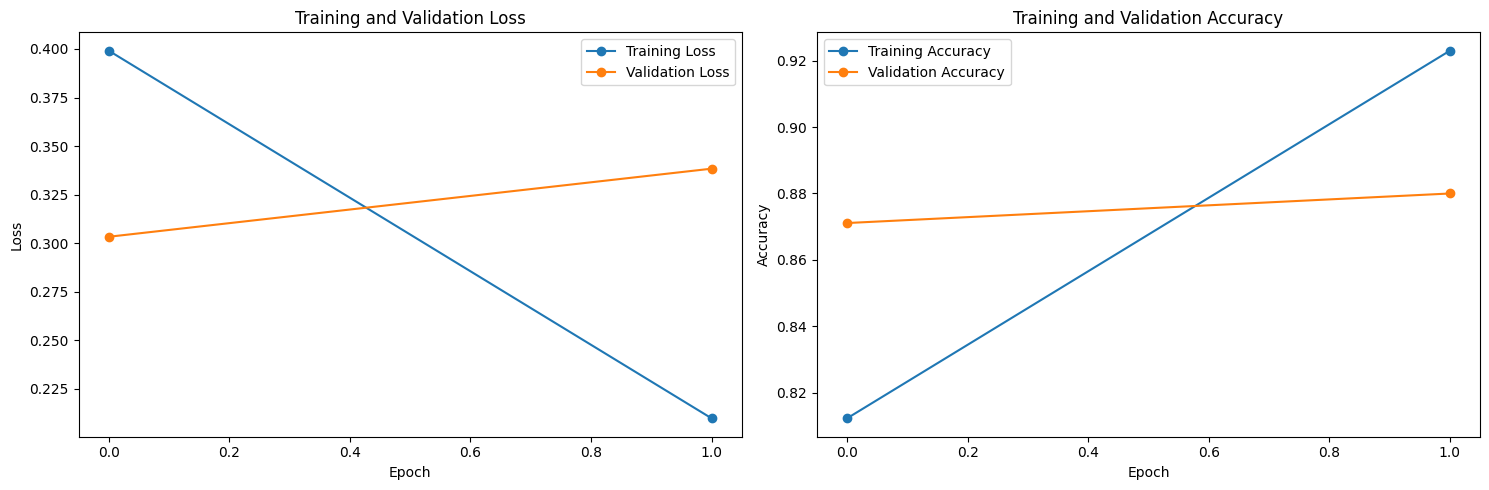

In [99]:

fig, axes =plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_losses, label='Training Loss', marker='o')
axes[0].plot(val_losses, label='Validation Loss', marker='o')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot(train_accuracies, label='Training Accuracy', marker='o')
axes[1].plot(val_accuracies, label='Validation Accuracy', marker='o')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()
plt.show()


Our model learns the training data fast, which is usaually expected with BERT-based models do.
The validation accuracy is already good and stable.
The validation loss is slightly rising which indicates the start of overfitting, but this is not a big problem since our training was short.
We don't need more epochs, as the results show that the model is already performing well.

Evaluating on test set...
Test Loss: 0.2936
Test Accuracy: 0.8908

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.90      0.89      1250
    Positive       0.90      0.88      0.89      1250

    accuracy                           0.89      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.89      0.89      0.89      2500



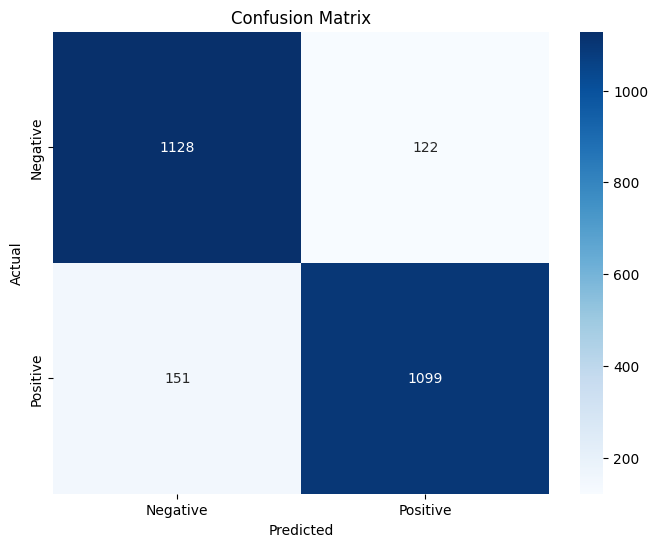

In [100]:
print("Evaluating on test set...")
test_loss, test_acc,test_preds, test_labels = eval_model(model, test_loader, device)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Negative', 'Positive']))
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',xticklabels=['Negative', 'Positive'],yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [108]:
model.save_pretrained('./sentiment_model_bis')
tokenizer.save_pretrained('./sentiment_model_bis')

('./sentiment_model_bis\\tokenizer_config.json',
 './sentiment_model_bis\\special_tokens_map.json',
 './sentiment_model_bis\\vocab.txt',
 './sentiment_model_bis\\added_tokens.json',
 './sentiment_model_bis\\tokenizer.json')

### 4. Test 

In [113]:
def predict_sentiment(text, model, tokenizer, device, max_length=256):
    model.eval()
    encoding = tokenizer(text,truncation=True,padding='max_length',max_length=max_length,return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs.logits, dim=1)
        confidence, prediction = torch.max(probabilities, dim=1)
    sentiment= "Positive" if prediction.item() == 1 else "Negative"
    confidence= confidence.item()
    return sentiment, confidence

sample_texts = ["If ever there was a masterpiece of comedy film, this is it.","Filmed in black and white to avoid making the two leading men look more atrocious than they already do." ]
print("The sample Predictions on original reviews:")
for text in sample_texts:
    sentiment, confidence = predict_sentiment(text, model, tokenizer, device)
    print(f"Review: {text}...")
    print(f"Sentiment:{sentiment} (Confidence:{confidence:.4f})")
    print()

The sample Predictions on original reviews:
Review: If ever there was a masterpiece of comedy film, this is it....
Sentiment:Positive (Confidence:0.9798)

Review: Filmed in black and white to avoid making the two leading men look more atrocious than they already do....
Sentiment:Negative (Confidence:0.7083)

